In [ ]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot

import os
import scipy
import awkward as ak
import time
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import *

import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [ ]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()

# for data_year in ['2022','2023','all']:
for data_year in ['all']:

    # path = "/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/data/raw/"
    # fpath_bkg[data_year] = path + f"data_{data_year}_goodLumi.root"
    if data_year == 'all':path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/'
    else: path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data{data_year}/v14/normalized/'
    if data_year == '2022':fpath['data'+data_year] = path + "DisplacedJet-EXOCSCCluster_Run2022-PromptReco_goodLumi.root"
    elif data_year == '2023':fpath['data'+data_year] = path + "Muon-EXOCSCCluster_Run2023-PromptReco_goodLumi.root"
    elif data_year == 'all':fpath['data'+data_year] = path + "EXOCSCCluster_Run2022_2023_goodLumi.root"

fpath['sig'] = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root'
NEvents = {}

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'].values()[0]
    # NEvents[k] = root_dir['NEvents'].counts()
    print("NEvents",NEvents[k])


dataall /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/EXOCSCCluster_Run2022_2023_goodLumi.root
NEvents 34804216.0
sig /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57555044.0
CPU times: user 396 ms, sys: 7.51 ms, total: 403 ms
Wall time: 402 ms


# apply selections

In [14]:
%%time


JET_PT_CUT = 30
MUON_PT_CUT = 30.0
N_RECHIT_CUT = 90

cscRechitClusterPhi0 = {}
cscRechitClusterPhi1 = {}
deltaPhi_cluster  = {}
cscRechitClusterDNN0  = {}
cscRechitClusterDNN1  = {}
cscRechitClusterTime0  = {}
cscRechitClusterTime1  = {}
cscRechitClusterSize0  = {}
cscRechitClusterSize1  = {}

cscRechitClusterEta = {}
cscRechitClusterPhi = {}
runNum = {}
HMTEff = {}
weight = {}

region_list = ['invertDNN', 'oot', 'signal']
for region in region_list:
    for tree_k in tree.keys():
        # if not region == 'signal': continue
        T = tree[tree_k]
        k = f'{region}_{tree_k}'


    ########### SELECTION: CLUSTERS ############
        me1 = (T['cscRechitClusterNRechitChamberPlus11'].array()+ T['cscRechitClusterNRechitChamberPlus12'].array()+\
        T['cscRechitClusterNRechitChamberMinus11'].array()+ T['cscRechitClusterNRechitChamberMinus12'].array())

        # cluster = 
        #one cluster to pass trigger
        # cluster0 = np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, T['cscRechitClusterTimeWeighted'].array() > -5)
        cluster = (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster = cluster & (me1 ==0)
        cluster = cluster & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster = cluster & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    

    ########### SELECTION: EVENTS ############
        sel_ev = T['HLT_CSCCSC'].array()
        # sel_ev  = np.logical_and(sel_ev,np.sum(cluster0, axis = 1) >= 1)
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster, axis = 1) == 2)

        cluster_pass_HLT = HLT_CSC(T['cscRechitClusterEta'].array(),T['cscRechitClusterNStation10'].array(),T['cscRechitClusterSize'].array())
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster_pass_HLT, axis = 1) >= 1) # at least one passes HLT
        
        # if met_cat == 'lowMET':sel_ev = np.logical_and(sel_ev ,T['met'].array() < 150)
        # else: sel_ev = sel_ev & (T['met'].array() > 150) & (T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev ,T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev,T['nCscRechitClusters'].array()==2)
        # print(np.count_nonzero(temp), np.count_nonzero(sel_ev))

    ########### BRANCHES ############
       ##### event variables ##### 
       
        cscRechitClusterPhi0[k] = T['cscRechitClusterPhi'].array()[cluster][sel_ev][:,0]
        cscRechitClusterPhi1[k] = T['cscRechitClusterPhi'].array()[cluster][sel_ev][:,1]
        deltaPhi_cluster[k] = deltaPhi(np.array(cscRechitClusterPhi0[k]), np.array(cscRechitClusterPhi1[k]))
        
        cscRechitClusterDNN0[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[cluster][sel_ev][:,0]
        cscRechitClusterDNN1[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[cluster][sel_ev][:,1]
        cscRechitClusterTime0[k] = T['cscRechitClusterTimeWeighted'].array()[cluster][sel_ev][:,0]
        cscRechitClusterTime1[k] = T['cscRechitClusterTimeWeighted'].array()[cluster][sel_ev][:,1]
        cscRechitClusterSize0[k] = T['cscRechitClusterSize'].array()[cluster][sel_ev][:,0]
        cscRechitClusterSize1[k] = T['cscRechitClusterSize'].array()[cluster][sel_ev][:,1]
        cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[cluster][sel_ev]
        deltaR_cluster[k] = ((cscRechitClusterEta[k][:,0]-cscRechitClusterEta[k][:,1])**2 + deltaPhi_cluster[k]**2)**0.5

            # 
        sel = (np.abs(deltaPhi_cluster[k])>1.8) & (deltaR_cluster[k] < 3.5)
        sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterTime0[k]>-5) & (cscRechitClusterTime0[k]<12.5)
        if 'oot' in region:
            sel = sel & (cscRechitClusterDNN1[k] > 0.96) & (cscRechitClusterTime1[k]<-12.5)
        elif 'invertDNN' in region:
            sel = sel & (cscRechitClusterDNN1[k] < 0.96) & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        elif 'signal' in region:
            sel = sel & (cscRechitClusterDNN1[k] > 0.96) & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        else: assert(False)
        deltaPhi_cluster[k] = deltaPhi_cluster[k][sel]
        cscRechitClusterSize1[k] = cscRechitClusterSize1[k][sel]
        HMTEff[k] = T['cscRechitClusterHMTEfficiency'].array()[sel_ev][sel]
        
        cluster_pass_HLT = cluster_pass_HLT[sel_ev][sel]
        HMTEff[k] = 1-HMTEff[k][cluster_pass_HLT]
        HMTEff[k] = 1-np.prod(HMTEff[k],axis=1)
        
        cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[cluster][sel_ev][sel]
        cscRechitClusterPhi[k] = T['cscRechitClusterPhi'].array()[cluster][sel_ev][sel]
        runNum[k] = T['runNum'].array()[sel_ev][sel]

        if 'data' in k:weight[k] = (T['weight'].array())[sel_ev][sel]*0.0 + 1                                                             
        else: weight[k] = (T['pileupWeight'].array()*T['weight'].array())[sel_ev][sel]*HMTEff[k]
        print("events in this region:", k, len(deltaPhi_cluster[k]), np.sum(weight[k]), len(weight[k]))

events in this region: invertDNN_dataall 410 410.0 410
events in this region: invertDNN_sig 462 371.36554 462
events in this region: oot_dataall 301 301.0 301
events in this region: oot_sig 1 0.096313916 1
events in this region: signal_dataall 161 161.0 161
events in this region: signal_sig 2491 2245.7266 2491
CPU times: user 51.4 s, sys: 4.65 s, total: 56 s
Wall time: 56 s


# check inverted DNN region

0.1901099681854248


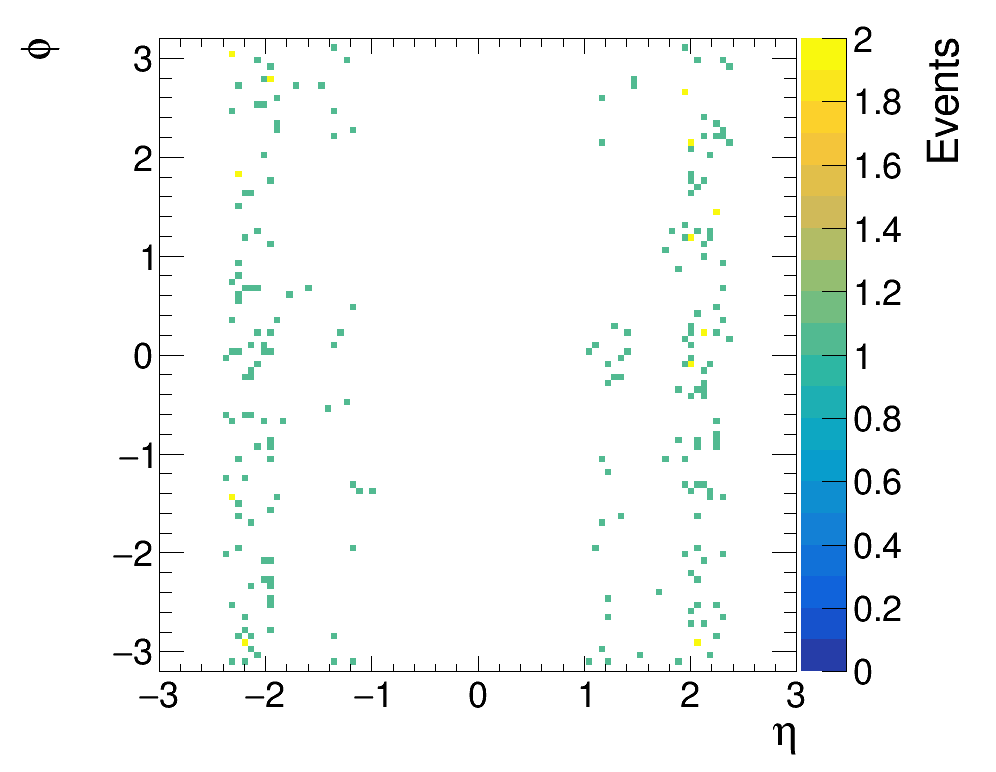

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
leg = rt.TLegend(0.5,0.7,0.8,0.9)
leg.SetBorderSize(0)
# plot_var = [cscRechitClusterSize1, deltaPhi_cluster]
# axis = ['N_{rechits}','#Delta#phi',]
# name = ['nhits','dphi']
# bins = [[25,50,500],[25,1.8,3.2]]


k = "invertDNN_dataall"
h = create_TH2D(np.column_stack(( np.array(cscRechitClusterEta[k][:,1]), np.array(cscRechitClusterPhi[k][:,1]))),\
               axis_title = ['#eta','#phi','Events'], binning=[100,-3,3,100,-3.2,3.2])
h.Draw('colz')

# print(np.min(runNum[k]),np.max(runNum[k]))
# h = create_TH1D( np.array(runNum[k]), axis_title = ['run number','Events'], binning=[5000,360000,371000])
# h.Draw()
# h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k],k.replace('all',''))

c.SetRightMargin(0.2)

c.Draw()

# c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".png")
# c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".pdf")
# c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".C")




print(time.time()-start_t)

## Create datacard with OOT data for optimization

In [15]:
datacard_version = 'v6'

In [30]:
data_key = 'oot_dataall'
signal_key = 'signal_sig'
a, b, c, d, pred = {}, {}, {}, {}, {}

outDataCardsDir=f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_1_0_pre4/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_run3HMT/csccsc/OOT_opt/{datacard_version}/"
tree_dir = outDataCardsDir.replace("datacards","limitTrees")
os.system(f"mkdir -p {outDataCardsDir}")
os.system(f"mkdir -p {tree_dir}")
modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"

sig_unc = {'ggH':[[0.2]*4]}
sig_unc_name = ['test']
signal_region = 'a'
prefix = 'csccsc_'

h = {
signal_key: rt.TH2D("","",22,80,300, 14,1.8,3.2),
data_key: rt.TH2D("","",22,80,300, 14,1.8,3.2),
}


for nhit_cut in np.arange(80,300,10):
    for dphi_cut in np.arange(1.8, 3.2, 0.1):
        
        k = signal_key
        for k in [data_key, signal_key]:
            
            if k == data_key: 
                TF = len(cscRechitClusterSize1['signal_dataall'])/len(cscRechitClusterSize1['oot_dataall'])
            else: TF = 1
            a[k] = np.sum(weight[k][(cscRechitClusterSize1[k]>=nhit_cut) &  (np.abs(deltaPhi_cluster[k])>=dphi_cut)]) * TF
            b[k] = np.sum(weight[k][(cscRechitClusterSize1[k]>=nhit_cut) &  (np.abs(deltaPhi_cluster[k])<dphi_cut)]) * TF
            c[k] = np.sum(weight[k][(cscRechitClusterSize1[k]<nhit_cut) &  (np.abs(deltaPhi_cluster[k])<dphi_cut)]) * TF
            d[k] = np.sum(weight[k][(cscRechitClusterSize1[k]<nhit_cut) &  (np.abs(deltaPhi_cluster[k])>=dphi_cut)]) * TF
            if c[k] == 0: pred[k] = 999
            else: pred[k] = b[k]*d[k]/c[k]
            
            if k == data_key:
                if b[k] < 1 or c[k] < 1 or d[k] < 1:continue
                unc_pred = (TF/c[k] + TF/b[k] + TF/d[k])**0.5*pred[k]
                # print(k,unc_pred,pred[k],a[k],b[k],c[k],d[k])
        if b[data_key] < 1 or c[data_key] < 1 or d[data_key] < 1:continue
        # print(nhit_cut, dphi_cut, a[signal_key], pred[data_key], a[signal_key]/pred[data_key], unc_pred, pred[data_key])
        
        
        xbin = h[data_key].GetXaxis().FindBin(nhit_cut)
        ybin = h[data_key].GetYaxis().FindBin(dphi_cut)
        h[data_key].SetBinContent(xbin,ybin,pred[data_key])
        h[signal_key].SetBinContent(xbin,ybin,a[signal_key])
            
        card_name = f'nhits{nhit_cut}_dphi'+str(round(dphi_cut,1)).replace(".","p")
        
        ## create datacards ##
        make_datacard_2tag(
        outDataCardsDir,
        card_name,
        {'ggH':[a[signal_key],b[signal_key],c[signal_key],d[signal_key]]}, #signal rate
        a[signal_key], 
        [pred[data_key],b[data_key],c[data_key],d[data_key]], #bkg rate
        [pred[data_key],b[data_key],c[data_key],d[data_key]], #observation
        [unc_pred/pred[data_key]], 
        ['syst'], 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
        )
        
        
        # break

# plot signal/bkg

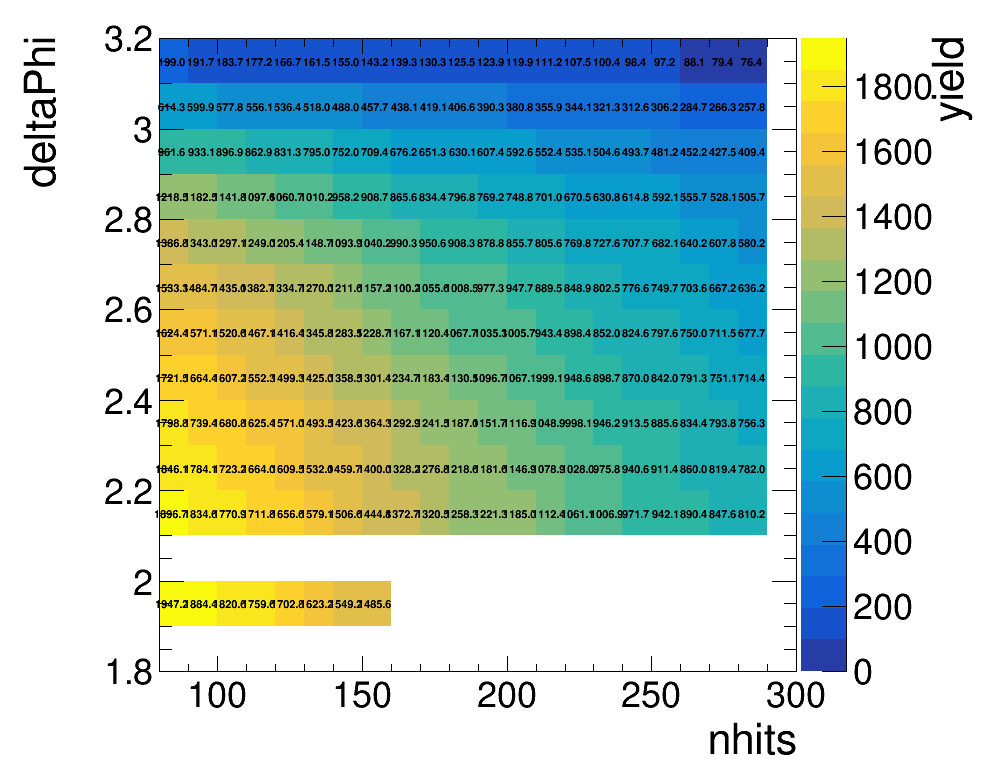

In [26]:
rt.gStyle.SetPaintTextFormat("1.1f");
c = rt.TCanvas('c','c', 1000, 800)

k = signal_key
# k = data_key
h[k].GetXaxis().SetTitle("nhits")
h[k].GetYaxis().SetTitle("deltaPhi")
h[k].GetZaxis().SetTitle("yield")
h[k].GetZaxis().SetTitleOffset(1.1)
h[k].SetMarkerSize(0.8)

h[k].Draw("colz text")
c.SetRightMargin(0.2)
c.Draw()

## Plot combine result

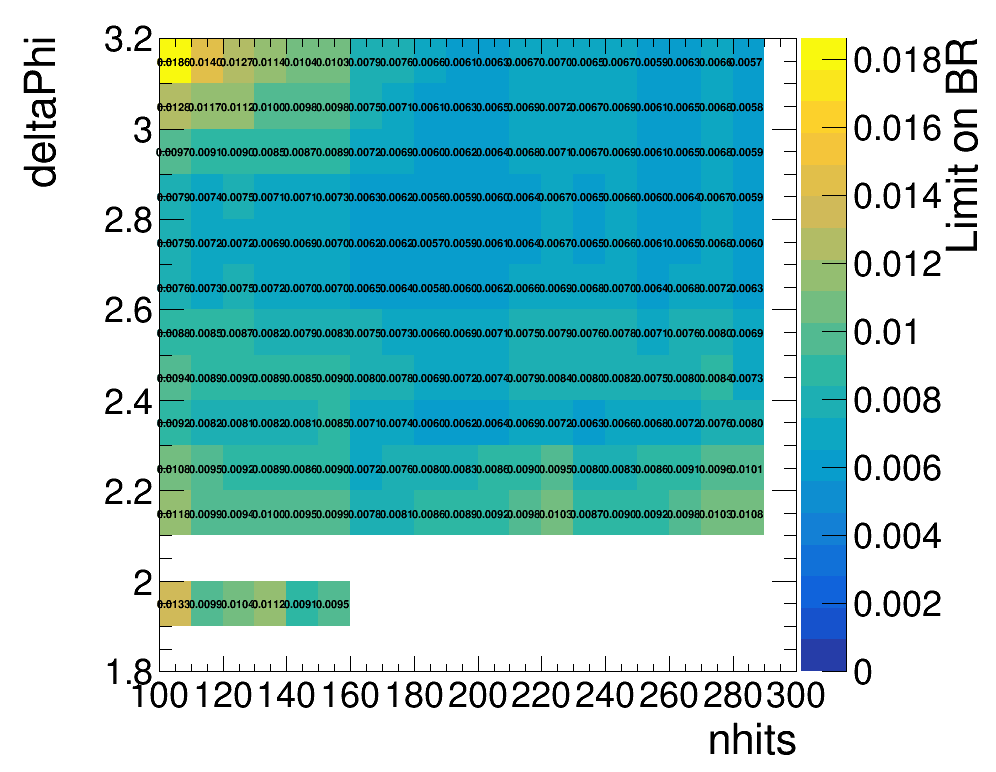

In [29]:
rt.gStyle.SetPaintTextFormat("1.4f");

c = rt.TCanvas('c','c', 1000, 800)
h_opt = rt.TH2D("","",20,100,300, 14,1.8,3.2)

for nhit_cut in np.arange(100,300,10):
    for dphi_cut in np.arange(1.8, 3.2, 0.1):
        
        ###### open datacard and limit ######
        card_name = f"nhits{nhit_cut}_dphi"+str(round(dphi_cut,1)).replace(".","p") 
        if not os.path.isfile(f"{outDataCardsDir}/{card_name}.txt"):continue
        signal_norm = readNorm(f"{outDataCardsDir}/{card_name}.txt")
        
        tree_name = f"higgsCombine.{card_name}.AsymptoticLimits.mH120.root"
        limitTree = tree_dir + '/' + tree_name
        if not os.path.isfile(limitTree):continue
        if len(uproot.open(limitTree).keys()) == 2:
                T = uproot.open(limitTree)['limit']                
                if len(np.array(T['limit'].array())>0):limit = np.array(T['limit'].array())/signal_norm
        
        
        xbin = h_opt.GetXaxis().FindBin(nhit_cut)
        ybin = h_opt.GetYaxis().FindBin(dphi_cut)
        h_opt.SetBinContent(xbin,ybin,limit[2])
        # if limit[2]<0.008: print(nhit_cut, dphi_cut, limit[2], h[data_key].GetBinContent(xbin,ybin), h[signal_key].GetBinContent(xbin,ybin))

h_opt.SetMarkerSize(0.8)
h_opt.GetXaxis().SetTitle("nhits")
h_opt.GetYaxis().SetTitle("deltaPhi")
h_opt.GetZaxis().SetTitle("Limit on BR")
h_opt.GetZaxis().SetTitleOffset(1.2)
h_opt.Draw("colz text")
c.SetRightMargin(0.2)
c.Draw()